# Setup

Ensure all dependencies are installed.


In [2]:
%pip install -U -r requirements.txt

  Cloning ssh://****@gitlab.utwente.nl/s2219735-bsc-research-project/mesh-to-points.git (to revision main) to /tmp/pip-install-1zdzs959/m2p_20edd22c5989495d8ef59a0a5681afc3
  Running command git clone --filter=blob:none --quiet 'ssh://****@gitlab.utwente.nl/s2219735-bsc-research-project/mesh-to-points.git' /tmp/pip-install-1zdzs959/m2p_20edd22c5989495d8ef59a0a5681afc3
  Resolved ssh://****@gitlab.utwente.nl/s2219735-bsc-research-project/mesh-to-points.git to commit 78899e62db635567c95b5e83565a036f4974d071
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


Check if we have GPU support, and if not, warn the user.


In [3]:
import torch
import warnings

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    warnings.warn("CUDA is not available. Running on CPU.")

CUDA is available!


Load our dataset...


In [4]:
import tempfile
import os
import zipfile
import shutil

import utils.file

from data_sources import DataSource, ModelNet40
from pointnet.dataset import ModelNetDataset

data_source: DataSource = ModelNet40()
data_size = utils.file.get_download_size(data_source.url)

temp_dir = tempfile.gettempdir()
zip_path = os.path.join(temp_dir, data_source.name + ".zip")
dataset_path = os.path.join(temp_dir, data_source.name)

if os.path.exists(zip_path) and utils.file.checksum(zip_path) == data_source.checksum:
    print("Zip already downloaded.")
else:
    utils.file.download_file(data_source.url, zip_path)
    print("Zip downloaded.")

if os.path.exists(dataset_path):
    print("Conflicting data folder found. Deleting existing folder...")
    shutil.rmtree(dataset_path)
    print("Folder deleted.")

print("Extracting data...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(dataset_path)
    print("Data extracted.")

npoints = 2500

train_dataset = ModelNetDataset(root=dataset_path, npoints=npoints, split="train")

test_dataset = ModelNetDataset(
    root=dataset_path,
    split="test",
    npoints=npoints,
)

print(
    f"Training data: {len(train_dataset)} samples with {len(train_dataset.classes)} classes"
)
print(
    f"Test data size: {len(test_dataset)} samples with {len(test_dataset.classes)} classes"
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Zip already downloaded.
Conflicting data folder found. Deleting existing folder...
Folder deleted.
Extracting data...
Data extracted.
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/chair/train/chair_0856.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/chair/train/chair_0092.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/chair/train/chair_0451.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/chair/train/chair_0452.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sofa/train/sofa_0458.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sofa/train/sofa_0409.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sofa/train/sofa_0562.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sofa/train/sofa_0640.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sof

# Training

Train a new classifier or load a new pre-trained one:


In [10]:
from pointnet.train_classification import train_classification
from pointnet.model import PointNetCls

classifier_path = ""  # pointnet/classifier.pth

if classifier_path and os.path.exists(classifier_path):
    print(f"Loading existing model from {classifier_path}...")
    classifier = PointNetCls(k=len(train_dataset.classes))
    classifier.load_state_dict(torch.load(classifier_path, weights_only=True))
    print("Classifier loaded successfully.")
else:
    classifier = train_classification(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        epochs=25,
        outf="./pointnet/cls",
    )

Random Seed:  3212


OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB. GPU 0 has a total capacity of 14.57 GiB of which 72.75 MiB is free. Process 3032760 has 6.85 GiB memory in use. Process 3079325 has 3.71 GiB memory in use. Process 3163579 has 3.93 GiB memory in use. Of the allocated memory 3.51 GiB is allocated by PyTorch, and 296.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Run a simple classification to get a visualization of our classifier.


Scores: [-18.455059051513672, -12.836451530456543, -15.84492015838623, -5.448758125305176, -12.273743629455566, -10.444089889526367, -13.062467575073242, -17.55986785888672, -5.460410118103027, -13.62863540649414, -19.007278442382812, -16.872974395751953, -4.426091194152832, -9.4406099319458, -11.371969223022461, -12.988898277282715, -16.027219772338867, -5.236804008483887, -11.138829231262207, -19.649919509887695, -10.539419174194336, -16.526636123657227, -20.567058563232422, -11.88191032409668, -16.516633987426758, -15.394034385681152, -16.704090118408203, -18.918142318725586, -15.372442245483398, -9.34158706665039, -10.574647903442383, -0.6145175099372864, -19.690406799316406, -18.12576675415039, -12.318641662597656, -0.8379719853401184, -12.988977432250977, -7.9024271965026855, -11.768133163452148, -18.108901977539062]
Expected class: person (8)
Predicted class: tent (31)


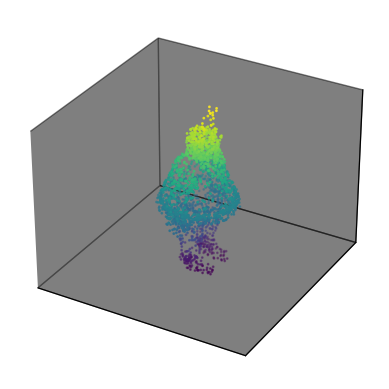

In [9]:
import random
import torch
from utils.plot import plot_points

i = random.randint(0, len(test_dataset) - 1)

input_data = test_dataset[i][0].unsqueeze(0)
input_data = input_data.transpose(1, 2)

classifier.eval()

with torch.no_grad():
    output = classifier(input_data)


scores: torch.Tensor = output[0][0]
print("Scores:", scores.tolist())
print(
    f"Expected class: {test_dataset.classes[int(test_dataset[i][1])]} ({int(test_dataset[i][1])})",
)
print(
    f"Predicted class: {test_dataset.classes[scores.argmax().item()]} ({scores.argmax().item()})"
)

points = input_data[0].transpose(0, 1).numpy()
plot_points(points)

Train the segmenter:


In [7]:
from pointnet.train_segmentation import train_segmentation

train_segmentation(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    epochs=25,
    class_choice=0,
    outf="./pointnet/seg",
)

Random Seed:  3295


ValueError: Expected input batch_size (80000) to match target batch_size (32).